In [104]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import statsmodels.api as sm

In [2]:
area_pre_feature_selection = pd.read_csv('../../data/pre_training/area_pre_feature_selection.csv')
district_pre_feature_selection = pd.read_csv('../../data/pre_training/district_pre_feature_selection.csv')

In [3]:
area_features = area_pre_feature_selection.drop('area_crimes_this_hour', axis=1)
district_features = district_pre_feature_selection.drop('district_crimes_this_hour', axis=1)

area_target = area_pre_feature_selection[['year', 'area_crimes_this_hour']]
district_target = district_pre_feature_selection[['year', 'district_crimes_this_hour']]

In [4]:
# break the area dataset into testing and training datasets
area_feature_training_data = area_features[area_features['year'] < 2020].reset_index(drop=True)
area_feature_testing_data = area_features[area_features['year'] == 2020].reset_index(drop=True)

area_target_training_data = area_target[area_target['year'] < 2020].reset_index(drop=True)
area_target_testing_data = area_target[area_target['year'] == 2020].reset_index(drop=True)

In [5]:
# break the district dataset into testing and training datasets
district_feature_training_data = district_features[district_features['year'] < 2020].reset_index(drop=True)
district_feature_testing_data = district_features[district_features['year'] == 2020].reset_index(drop=True)

district_target_training_data = district_target[district_target['year'] < 2020].reset_index(drop=True)
district_target_testing_data = district_target[district_target['year'] == 2020].reset_index(drop=True)

In [6]:
area_target_training_data = area_target_training_data.drop('year', axis=1)
area_target_testing_data = area_target_testing_data.drop('year', axis=1)
district_target_training_data = district_target_training_data.drop('year', axis=1)
district_target_testing_data = district_target_testing_data.drop('year', axis=1)

##### Final Feature Engineering

In [7]:
lr_area_feature_training_data = area_feature_training_data.drop('date_hour', axis=1)
lr_area_feature_testing_data = area_feature_testing_data.drop('date_hour', axis=1)

lr_district_feature_training_data = district_feature_training_data.drop('date_hour', axis=1)
lr_district_feature_testing_data = district_feature_testing_data.drop('date_hour', axis=1)

In [8]:
# target encoding of district/area columns
area_means = area_pre_feature_selection.groupby('area_id')['area_crimes_this_hour'].mean()
district_means = district_pre_feature_selection.groupby('district')['district_crimes_this_hour'].mean()

lr_area_feature_training_data['area_id_target_encoded'] = lr_area_feature_training_data['area_id'].map(area_means)
lr_area_feature_testing_data['area_id_target_encoded'] = lr_area_feature_testing_data['area_id'].map(area_means)

lr_district_feature_training_data['district_target_encoded'] = lr_district_feature_training_data['district'].map(district_means)
lr_district_feature_testing_data['district_target_encoded'] = lr_district_feature_testing_data['district'].map(district_means)

In [9]:
# frequency encoding of district/area columns
area_freq = area_pre_feature_selection['area_id'].value_counts() / len(area_pre_feature_selection)
district_freq = district_pre_feature_selection['district'].value_counts() / len(district_pre_feature_selection)

lr_area_feature_training_data['area_id_freq_encoded'] = lr_area_feature_training_data['area_id'].map(area_freq)
lr_area_feature_testing_data['area_id_freq_encoded'] = lr_area_feature_testing_data['area_id'].map(area_freq)

lr_district_feature_training_data['district_freq_encoded'] = lr_district_feature_training_data['district'].map(district_freq)
lr_district_feature_testing_data['district_freq_encoded'] = lr_district_feature_testing_data['district'].map(district_freq)

In [10]:
lr_area_feature_training_data.drop('area_id', axis=1, inplace=True)
lr_area_feature_testing_data.drop('area_id', axis=1, inplace=True)

lr_district_feature_training_data.drop('district', axis=1, inplace=True)
lr_district_feature_testing_data.drop('district', axis=1, inplace=True)

In [11]:
def patch_datatypes(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].astype(np.float32)

    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].astype(np.int32)    
      
    return df

In [12]:
lr_area_feature_training_data = patch_datatypes(lr_area_feature_training_data)

In [13]:
lr_area_feature_testing_data = patch_datatypes(lr_area_feature_testing_data)

In [14]:
lr_district_feature_training_data = patch_datatypes(lr_district_feature_training_data)

In [15]:
lr_district_feature_testing_data = patch_datatypes(lr_district_feature_testing_data)

In [111]:
def generate_correlation_heatmap(df, figsize, title, save_name):
    # Generate a mask to onlyshow the bottom triangle
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))

    # generate heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
    plt.title(title)
    plt.savefig(f'../results/linear_regression/{save_name}.png')
    plt.show()

In [ ]:
generate_correlation_heatmap(lr_area_feature_training_data)

In [ ]:
generate_correlation_heatmap(lr_district_feature_training_data)

##### Using VIF to Remove Multicollinearity

In [ ]:
# Function to compute VIF for all features
def compute_vif(feature_df):
    print(f"{datetime.now()} - Starting VIF computation")
    X = feature_df.copy()
    # The calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # Create dataframe to store VIF values
    vif = pd.DataFrame()
    vif["feature"] = X.columns
    vif["vif"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['feature'] != 'intercept']
    
    print(f"{datetime.now()} - Completed VIF computation")
    return vif

In [ ]:
# Function to optimize VIF by dropping features with high VIF values
def optimize_vif(feature_df, vif_threshold):
    print(f"{datetime.now()} - Starting VIF optimization")
    df = feature_df.copy()       

    vif_df = compute_vif(feature_df)
    
    while (vif_df['vif'] >= vif_threshold).any():
        print(f"{datetime.now()} - Current VIF values:\n{vif_df}")
        largest_vif_feature = vif_df.loc[vif_df['vif'].idxmax(), 'feature']
        print(f"{datetime.now()} - Dropping feature: {largest_vif_feature} with VIF score of: {vif_df['vif'].max()}")
        df = df.drop(columns=[largest_vif_feature])
        vif_df = compute_vif(df)
    
    print(f"{datetime.now()} - Completed VIF optimization")
    return vif_df

In [ ]:
lr_area_selected_features_ten = optimize_vif(lr_area_feature_training_data, 10)

In [ ]:
lr_district_selected_features_ten = optimize_vif(lr_district_feature_training_data, 10)

In [17]:
lr_area_selected_features_ten = pd.DataFrame([
    "day",
    "hour",
    "year",
    "month",
    "day_of_week",
    "area_unemployment",
    "area_per_capita_income",
    "area_no_hs_dip",
    "area_gov_depend",
    "area_crowded_housing",
    "area_below_pov",
    "district",
    "police_stations_distance_0.1",
    "police_stations_distance_0.3",
    "police_stations_distance_0.5",
    "police_stations_distance_1",
    "police_stations_distance_3",
    "bike_stations_distance_0.1",
    "bike_stations_distance_0.3",
    "bike_stations_distance_0.5",
    "bus_stops_distance_0.1",
    "bus_stops_distance_0.3",
    "train_stations_distance_0.1",
    "train_stations_distance_0.3",
    "train_stations_distance_0.5",
    "train_stations_distance_1",
    "train_stations_distance_5",
    "alleylights_distance_0.1",
    "alleylights_distance_0.3",
    "alleylights_distance_0.5",
    "alleylights_distance_3",
    "streetlights_allout_distance_0.1",
    "streetlights_allout_distance_0.3",
    "streetlights_allout_distance_0.5",
    "streetlights_allout_distance_1",
    "streetlights_allout_distance_5",
    "streetlights_oneout_distance_0.1",
    "streetlights_oneout_distance_0.3",
    "streetlights_oneout_distance_0.5",
    "streetlights_oneout_distance_1",
    "bike_rides_within_0.1_and_5_min",
    "bike_rides_within_0.3_and_5_min",
    "bike_rides_within_0.5_and_5_min",
    "bike_rides_within_0.1_and_15_min",
    "hourly_bike_rides",
    "district_unemployment",
    "district_per_capita_income",
    "district_no_hs_dip",
    "rides",
    "district_crimes_1_hours_prev",
    "district_crimes_3_hours_prev",
    "area_crimes_1_hours_prev",
    "area_crimes_3_hours_prev",
    "area_id_target_encoded",
    "area_id_freq_encoded"
], columns=['feature'])

In [18]:
lr_district_selected_features_ten = pd.DataFrame([
    "day",
    "hour",
    "year",
    "month",
    "day_of_week",
    "area_per_capita_income",
    "area_gov_depend",
    "area_crowded_housing",
    "area_below_pov",
    "police_stations_distance_0.1",
    "police_stations_distance_0.3",
    "police_stations_distance_0.5",
    "police_stations_distance_1",
    "police_stations_distance_3",
    "bike_stations_distance_0.1",
    "bike_stations_distance_0.3",
    "bus_stops_distance_0.1",
    "bus_stops_distance_0.3",
    "train_stations_distance_0.1",
    "train_stations_distance_0.3",
    "train_stations_distance_1",
    "train_stations_distance_5",
    "alleylights_distance_0.1",
    "alleylights_distance_0.3",
    "alleylights_distance_1",
    "alleylights_distance_5",
    "streetlights_allout_distance_0.1",
    "streetlights_allout_distance_0.3",
    "streetlights_allout_distance_0.5",
    "streetlights_allout_distance_1",
    "streetlights_allout_distance_5",
    "streetlights_oneout_distance_0.1",
    "streetlights_oneout_distance_0.3",
    "streetlights_oneout_distance_0.5",
    "streetlights_oneout_distance_3",
    "bike_rides_within_0.1_and_5_min",
    "bike_rides_within_0.3_and_5_min",
    "bike_rides_within_0.5_and_5_min",
    "bike_rides_within_0.1_and_15_min",
    "hourly_bike_rides",
    "district_per_capita_income",
    "district_crowded_housing",
    "disadvantaged_score",
    "rides",
    "district_crimes_1_hours_prev",
    "district_crimes_3_hours_prev",
    "district_crimes_6_hours_prev",
    "area_crimes_1_hours_prev",
    "area_crimes_3_hours_prev",
    "district_target_encoded",
    "district_freq_encoded"
], columns=['feature'])

In [61]:
area_target_training_data = area_target_training_data.values.ravel()
district_target_training_data = district_target_training_data.values.ravel()

##### Using SFS for Feature Selection

In [19]:
area_model = LinearRegression()
area_sfs = SFS(area_model, k_features='best', forward=True, floating=False, scoring='neg_mean_squared_error', n_jobs=12, cv=5, verbose=2)

In [20]:
lr_area_feature_training_data = lr_area_feature_training_data[list(lr_area_selected_features_ten['feature'].values)]

In [ ]:
area_sfs.fit(lr_area_feature_training_data, area_target_training_data)

In [26]:
area_sfs = SFS(area_model, k_features=(9, 19), forward=True, floating=False, scoring='neg_mean_squared_error', cv=5, n_jobs=12, verbose=2)

In [ ]:
area_sfs.fit(lr_area_feature_training_data, area_target_training_data)

In [50]:
area_best_avg_score = -1 * float('inf')
area_best_subset = None

# Iterate through the dictionary to find the best subset
for subset, values in area_sfs.subsets_.items():
    avg_score = values['avg_score']
    if avg_score > area_best_avg_score:
        area_best_avg_score = avg_score
        area_best_subset = values['feature_idx']

area_best_features = [col for idx, col in enumerate(lr_area_feature_training_data.columns) if idx in area_best_subset]

In [83]:
district_model = LinearRegression()
district_sfs = SFS(district_model, k_features='best', forward=True, floating=False, scoring='neg_mean_squared_error', cv=5, n_jobs=15, verbose=2)

In [84]:
lr_district_feature_training_data = lr_district_feature_training_data[list(lr_district_selected_features_ten['feature'].values)]

In [85]:
district_sfs.fit(lr_district_feature_training_data, district_target_training_data)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    1.6s
[Parallel(n_jobs=15)]: Done  48 out of  51 | elapsed:    3.1s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  51 out of  51 | elapsed:    3.1s finished

[2024-08-02 14:34:52] Features: 1/51 -- score: -2.297517061690237e-05[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    1.0s
[Parallel(n_jobs=15)]: Done  47 out of  50 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  50 out of  50 | elapsed:    3.2s finished

[2024-08-02 14:34:56] Features: 2/51 -- score: -2.2693884038763534e-05[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    1.5s
[Parallel(n_jobs=15)]: Done  45 out of  49 | elapsed:    4.4s remaining:    0.3s
[Parallel(n_jobs=15)]: Done  49 out of  49 | elapsed:    

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(1, 51),
                          n_jobs=15, scoring='neg_mean_squared_error',
                          verbose=2)

In [86]:
district_best_avg_score = -1 * float('inf')
district_best_subset = None

# Iterate through the dictionary to find the best subset
for subset, values in district_sfs.subsets_.items():
    avg_score = values['avg_score']
    if avg_score > district_best_avg_score:
        district_best_avg_score = avg_score
        district_best_subset = values['feature_idx']

district_best_features = [col for idx, col in enumerate(lr_district_feature_training_data.columns) if idx in district_best_subset]

In [88]:
area_best_features = [
    'day',
    'hour',
    'bike_stations_distance_0.1',
    'bike_stations_distance_0.3',
    'bike_stations_distance_0.5',
    'bike_rides_within_0.3_and_5_min',
    'hourly_bike_rides',
    'district_unemployment',
    'district_no_hs_dip',
    'area_crimes_1_hours_prev',
    'area_crimes_3_hours_prev',
    'area_id_target_encoded',
    'area_id_freq_encoded'
]

In [89]:
district_best_features = [
    'day',
    'hour',
    'month',
    'area_per_capita_income',
    'area_below_pov',
    'police_stations_distance_0.5',
    'police_stations_distance_3',
    'bus_stops_distance_0.3',
    'train_stations_distance_5',
    'alleylights_distance_1',
    'alleylights_distance_5',
    'streetlights_oneout_distance_0.3',
    'bike_rides_within_0.3_and_5_min',
    'bike_rides_within_0.5_and_5_min',
    'hourly_bike_rides',
    'district_per_capita_income',
    'disadvantaged_score',
    'district_crimes_1_hours_prev',
    'district_crimes_3_hours_prev',
    'district_crimes_6_hours_prev',
    'area_crimes_1_hours_prev',
    'area_crimes_3_hours_prev',
    'district_target_encoded'
]

##### Model Training

In [90]:
# Define the final area model
lr_area_feature_training_data = lr_area_feature_training_data[area_best_features]
lr_area_feature_testing_data = lr_area_feature_testing_data[area_best_features]

In [91]:
# Define the final district model
lr_district_feature_training_data = lr_district_feature_training_data[district_best_features]
lr_district_feature_testing_data = lr_district_feature_testing_data[district_best_features]

In [92]:
# Train the final area model
area_final_lr_model = LinearRegression()
area_final_lr_model.fit(lr_area_feature_training_data, area_target_training_data)

LinearRegression()

In [93]:
# Train the final district model
district_final_lr_model = LinearRegression()
district_final_lr_model.fit(lr_district_feature_training_data, district_target_training_data)

LinearRegression()

##### Model Testing

In [94]:
# Predict using the area model
area_predictions = area_final_lr_model.predict(lr_area_feature_testing_data)

In [95]:
# Calculate evaluation metrics for the area model
area_mse = mean_squared_error(area_target_testing_data, area_predictions)
area_rmse = np.sqrt(area_mse)
area_mae = mean_absolute_error(area_target_testing_data, area_predictions)
area_r2 = r2_score(area_target_testing_data, area_predictions)

# Print evaluation metrics for the area model
print("Area Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {area_mse}")
print(f"Root Mean Squared Error (RMSE): {area_rmse}")
print(f"Mean Absolute Error (MAE): {area_mae}")
print(f"R^2 Score: {area_r2}")

Area Model Performance Metrics:
Mean Squared Error (MSE): 4.885782904780354e-06
Root Mean Squared Error (RMSE): 0.002210380714895141
Mean Absolute Error (MAE): 0.0011643645076859163
R^2 Score: 0.20378975050183634


In [96]:
# Predict using the district model
district_predictions = district_final_lr_model.predict(lr_district_feature_testing_data)

In [97]:
# Calculate evaluation metrics for the district model
district_mse = mean_squared_error(district_target_testing_data, district_predictions)
district_rmse = np.sqrt(district_mse)
district_mae = mean_absolute_error(district_target_testing_data, district_predictions)
district_r2 = r2_score(district_target_testing_data, district_predictions)

# Print evaluation metrics for the district model
print("District Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {district_mse}")
print(f"Root Mean Squared Error (RMSE): {district_rmse}")
print(f"Mean Absolute Error (MAE): {district_mae}")
print(f"R^2 Score: {district_r2}")

District Model Performance Metrics:
Mean Squared Error (MSE): 1.5084154143745346e-05
Root Mean Squared Error (RMSE): 0.003883832404178294
Mean Absolute Error (MAE): 0.002441091445605755
R^2 Score: 0.21260756249646218


##### Analyzing Feature Importances

In [98]:
area_coef_df = pd.DataFrame({
    'Feature': lr_area_feature_training_data.columns,
    'Coefficient': area_final_lr_model.coef_
})

# Sort the DataFrame by the absolute value of the coefficients
area_coef_df['Abs_Coefficient'] = area_coef_df['Coefficient'].abs()
area_coef_df = area_coef_df.sort_values(by='Abs_Coefficient', ascending=False)
area_coef_df

,Feature,Coefficient,Abs_Coefficient
11,area_id_target_encoded,0.665301,0.665301
10,area_crimes_3_hours_prev,0.063339,0.063339
9,area_crimes_1_hours_prev,0.026637,0.026637
6,hourly_bike_rides,0.008739,0.008739
12,area_id_freq_encoded,-0.008554,0.008554
4,bike_stations_distance_0.5,0.001435,0.001435
7,district_unemployment,0.000822,0.000822
8,district_no_hs_dip,0.000699,0.000699
5,bike_rides_within_0.3_and_5_min,0.000695,0.000695
3,bike_stations_distance_0.3,0.000469,0.000469


In [99]:
district_coef_df = pd.DataFrame({
    'Feature': lr_district_feature_training_data.columns,
    'Coefficient': district_final_lr_model.coef_
})

# Sort the DataFrame by the absolute value of the coefficients
district_coef_df['Abs_Coefficient'] = district_coef_df['Coefficient'].abs()
district_coef_df = district_coef_df.sort_values(by='Abs_Coefficient', ascending=False)
district_coef_df

,Feature,Coefficient,Abs_Coefficient
22,district_target_encoded,0.523110,0.523110
17,district_crimes_1_hours_prev,0.047770,0.047770
18,district_crimes_3_hours_prev,0.036623,0.036623
21,area_crimes_3_hours_prev,0.028232,0.028232
14,hourly_bike_rides,0.013410,0.013410
19,district_crimes_6_hours_prev,0.006631,0.006631
20,area_crimes_1_hours_prev,0.004541,0.004541
16,disadvantaged_score,0.002635,0.002635
15,district_per_capita_income,0.002158,0.002158
7,bus_stops_distance_0.3,0.001866,0.001866


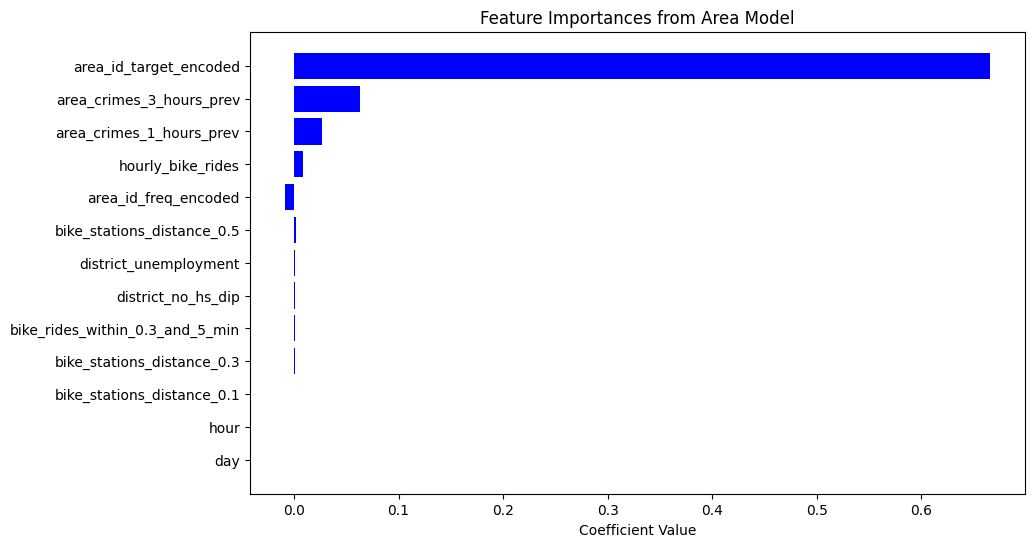

In [100]:
# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(area_coef_df['Feature'], area_coef_df['Coefficient'], color='blue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importances from Area Model')
plt.gca().invert_yaxis()  
plt.savefig('../results/linear_regression/area_feature_coefficients.png')
plt.show()

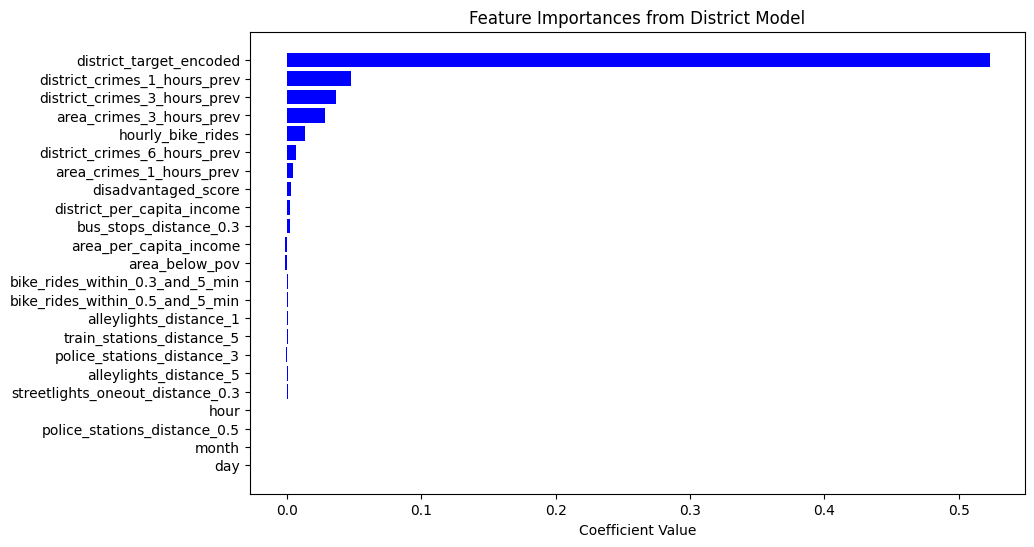

In [101]:
# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(district_coef_df['Feature'], district_coef_df['Coefficient'], color='blue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importances from District Model')
plt.gca().invert_yaxis()  
plt.savefig('../results/linear_regression/district_feature_coefficients.png')
plt.show()

In [105]:
lr_area_feature_training_data_const = sm.add_constant(lr_area_feature_training_data)
lr_area_feature_testing_data_const = sm.add_constant(lr_area_feature_testing_data)

# Fit the model using statsmodels
sm_model = sm.OLS(area_target_training_data, lr_area_feature_training_data_const).fit()

# Print the summary to get p-values and other statistics
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                 2.634e+05
Date:                Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                        14:49:55   Log-Likelihood:             4.8347e+07
No. Observations:            10659456   AIC:                        -9.669e+07
Df Residuals:                10659442   BIC:                        -9.669e+07
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [106]:
lr_district_feature_training_data_const = sm.add_constant(lr_district_feature_training_data)
lr_district_feature_testing_data_const = sm.add_constant(lr_district_feature_testing_data)

# Fit the model using statsmodels
sm_model = sm.OLS(district_target_training_data, lr_district_feature_training_data_const).fit()

# Print the summary to get p-values and other statistics
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                 1.056e+04
Date:                Fri, 02 Aug 2024   Prob (F-statistic):               0.00
Time:                        14:49:56   Log-Likelihood:             3.1858e+06
No. Observations:              806472   AIC:                        -6.371e+06
Df Residuals:                  806448   BIC:                        -6.371e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

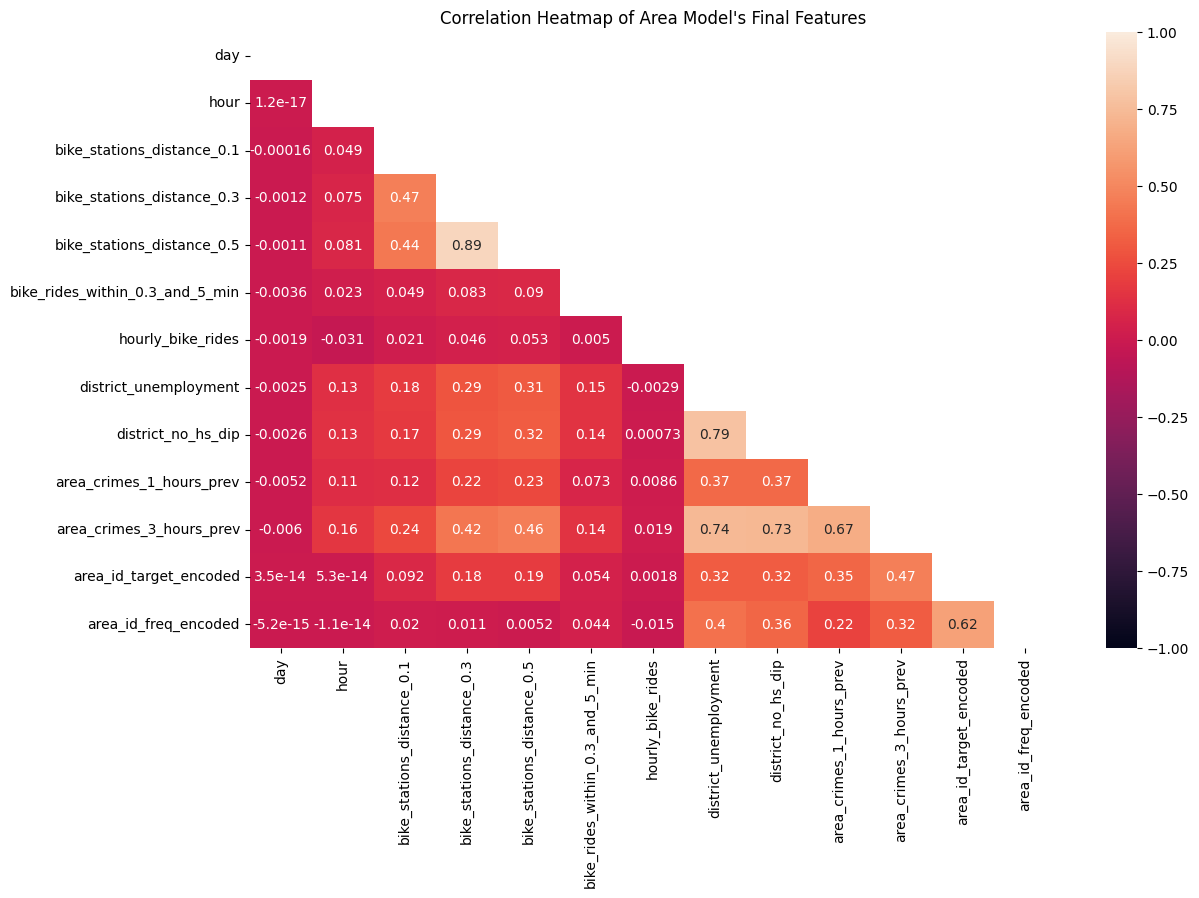

In [115]:
generate_correlation_heatmap(lr_area_feature_training_data, (13, 8), "Correlation Heatmap of Area Model's Final Features", 'area_final_features_corr')

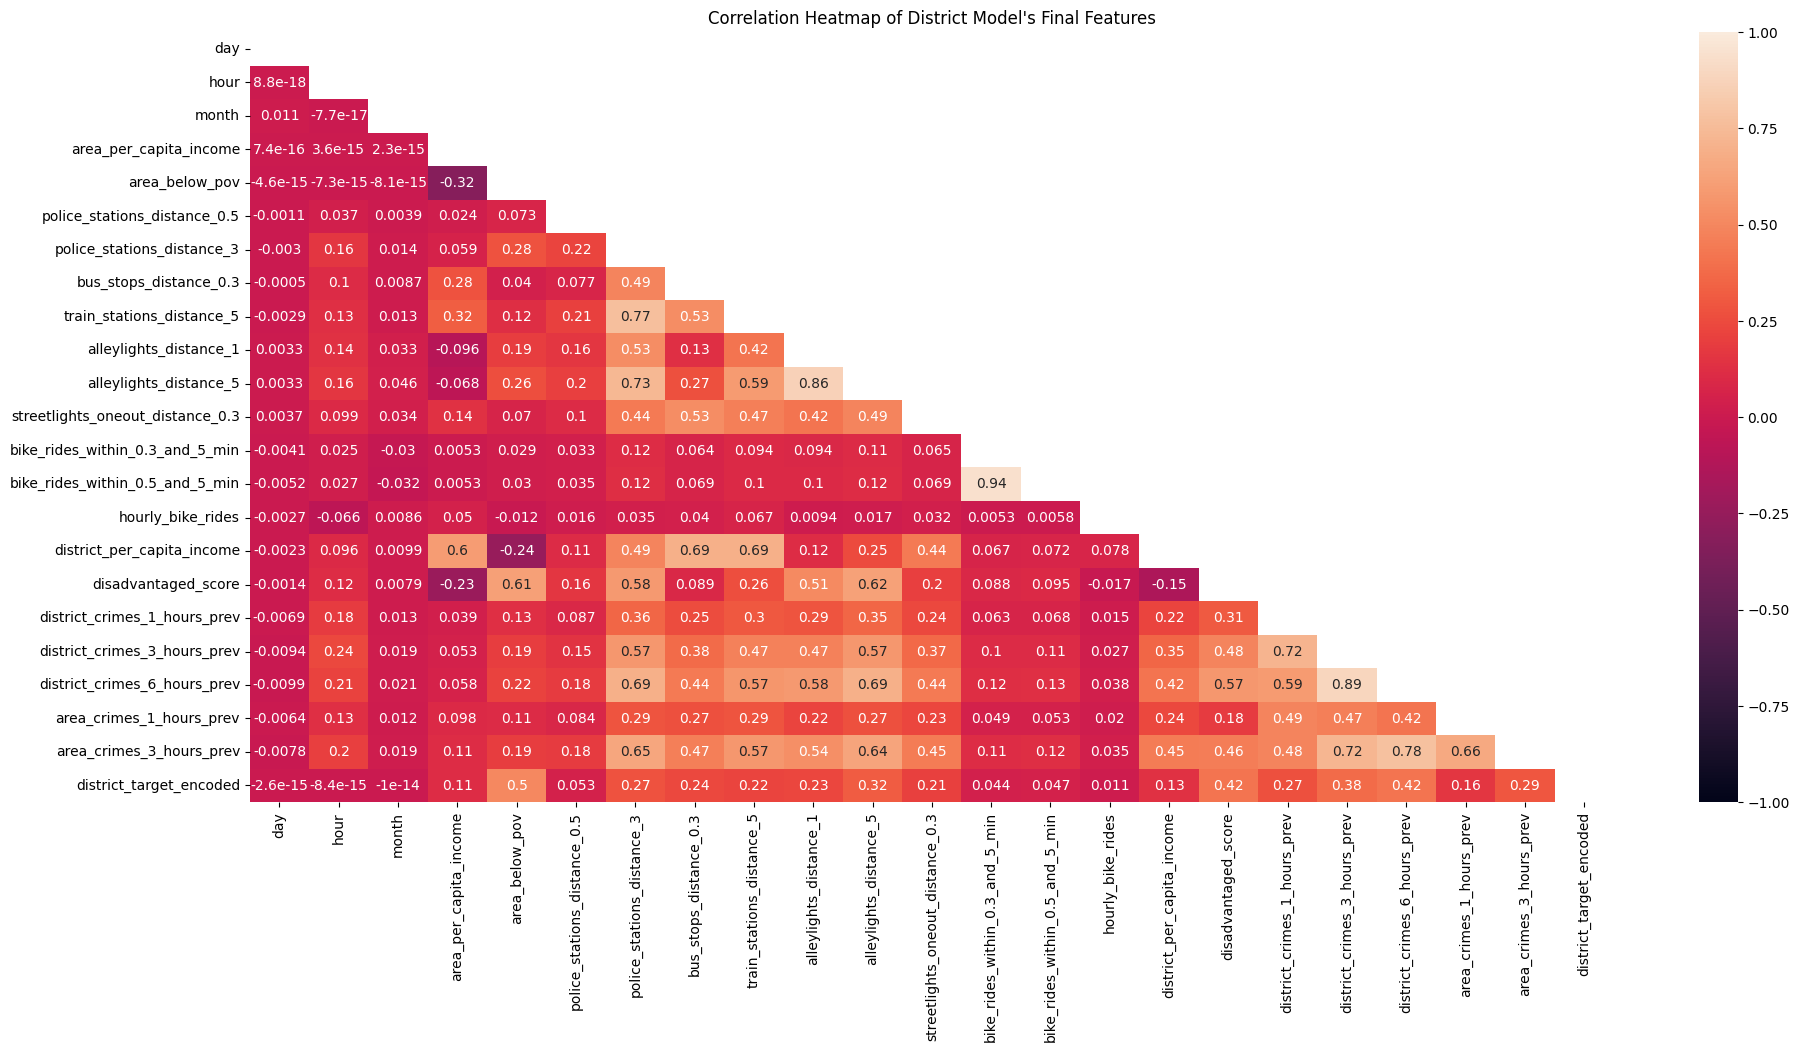

In [118]:
generate_correlation_heatmap(lr_district_feature_training_data, (22, 10), "Correlation Heatmap of District Model's Final Features", 'district_final_features_corr')